In [1]:
import numpy as np
import wandb
import time
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 

Data Preprocessing

In [2]:
out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

# data = np.load('test-prediction-submission-file.npz')
data = np.load('hidden-test-prediction-submission-file.npz')
upast_test = data['upast'] #N by u[k-15],u[k-14],...,u[k-1]
thpast_test = data['thpast'] #N by y[k-15],y[k-14],...,y[k-1]
# thpred = data['thnow'] #all zeros

def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

na = 10
nb = 10
Xtrain, Ytrain = create_IO_data(u_train, th_train, na, nb)

The linear model

In [3]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(Xtrain,Ytrain)
Ytrain_pred = reg.predict(Xtrain)

print('train prediction errors:')
print('RMS:', np.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
print('RMS:', np.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((Ytrain_pred-Ytrain)**2)**0.5/Ytrain.std()*100,'%')

 #only select the ones that are used in the example
Xtest = np.concatenate([upast_test[:,15-nb:], thpast_test[:,15-na:]],axis=1)

Ypredict = reg.predict(Xtest)
assert len(Ypredict)==len(upast_test), 'number of samples changed!!'

# np.savez('hidden-test-prediction-example-submission-file.npz', upast=upast_test, thpast=thpast_test, thnow=Ypredict)


train prediction errors:
RMS: 0.004812888250791686 radians
RMS: 0.27575818403846486 degrees
NRMS: 1.0039294104599579 %


New data preprocessing

In [4]:
out = np.load('training-val-test-data.npz')
th_train = out['th']
u_train = out['u']

na = 10
nb = 10
X, Y = create_IO_data(u_train, th_train, na, nb)

# Split into train/val/test
Xtemp, Xtest_final, Ytemp, Ytest_final = train_test_split(X, Y, test_size=0.15, random_state=42)
Xtrain_final, Xval, Ytrain_final, Yval = train_test_split(Xtemp, Ytemp, test_size=0.1765, random_state=42)


The NN

In [5]:
class Network(nn.Module):
    def __init__(self, n_hidden_nodes=40, n_in=2*na):
        super(Network,self).__init__()
        self.layer1 = nn.Linear(n_in,n_hidden_nodes).double()
        self.layer2 = nn.Linear(n_hidden_nodes,n_hidden_nodes).double()
        self.layer3 = nn.Linear(n_hidden_nodes,1).double()

    def forward(self,u):
        x1 = torch.nn.functional.leaky_relu(self.layer1(u))
        x2 = torch.nn.functional.leaky_relu(self.layer2(x1))
        y = self.layer3(x2)[:, 0]
        return y


Training the network

In [13]:
# Initialize W&B
wandb.init(
    project="5SC28",
    name="1 hidden 40 nodes leaky window of 10 unnormalized_3",
    config={
        "n_hidden_nodes": 40,
        "learning_rate": 0.001,
        "epochs": 1000,
        "batch_size": 256,
        "batched": True,
        "lr_decay": "plateau",         # options: "step", "plateau"        
        "lr_gamma": 0.5,
        "lr_step_size": 500
    }
)

train_losses = []
val_losses = []
train_NRMS_list = []
val_NRMS_list = []

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model setup
n_hidden_nodes = wandb.config.n_hidden_nodes
model = Network(n_hidden_nodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
wandb.watch(model, log="all")

# Learning rate scheduler
if wandb.config.lr_decay == "step":
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=wandb.config.lr_step_size,
        gamma=wandb.config.lr_gamma
    )
elif wandb.config.lr_decay == "plateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=wandb.config.lr_gamma,
        patience=20,
    )
else:
    scheduler = None

# Convert to torch tensors
Xtrain_tensor = torch.tensor(Xtrain_final).to(device)
Ytrain_tensor = torch.tensor(Ytrain_final).to(device)
Xval_tensor = torch.tensor(Xval).to(device)
Yval_tensor = torch.tensor(Yval).to(device)
Xtest_tensor = torch.tensor(Xtest_final).to(device)
Ytest_tensor = torch.tensor(Ytest_final).to(device)

# y_mean = y_tensor.mean()
# y_std = y_tensor.std()
# u_tensor = (u_tensor - u_tensor.mean()) / u_tensor.std()
# y_tensor = (y_tensor - y_mean) / y_std

grads = []
t_start = time.time()

# Training loop
for epoch in range(wandb.config.epochs):
    model.train()
    if wandb.config.batched:
        for i in range(0, len(Xtrain_tensor) - wandb.config.batch_size, wandb.config.batch_size):
            optimizer.zero_grad()
            y = model(Xtrain_tensor[i:i + wandb.config.batch_size])
            loss = torch.mean((y - Ytrain_tensor[i:i + wandb.config.batch_size]) ** 2)
            loss.backward()
            optimizer.step()
            batch_grads = [torch.mean(par.grad**2).item()**0.5 for par in list(model.parameters())[::2]]
            grads.append(batch_grads)
    else:
        optimizer.zero_grad()
        y = model(Xtrain_tensor)
        loss = torch.mean((y - Ytrain_tensor) ** 2)
        loss.backward()
        optimizer.step()
        batch_grads = [torch.mean(par.grad**2).item()**0.5 for par in list(model.parameters())[::2]]
        grads.append(batch_grads)

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(Xval_tensor)
        val_loss = torch.mean((val_pred - Yval_tensor) ** 2)
        val_nrms = val_loss.item() / torch.std(Yval_tensor).item()

    # # Compute NRMS
    # NRMS = Loss.item() / torch.std(y_tensor).item()

    if scheduler:
        if wandb.config.lr_decay == "plateau":
            scheduler.step(val_loss.item())
        else:
            scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
    else:
        current_lr = wandb.config.learning_rate

    train_nrms = loss.item() / torch.std(Ytrain_tensor).item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_NRMS_list.append(train_nrms)
    val_NRMS_list.append(val_nrms)

    wandb.log({
        "epoch": epoch,
        "train_loss": loss.item(),
        "train_NRMS": train_nrms,
        "val_loss": val_loss.item(),
        "val_NRMS": val_nrms,
        "updates_per_sec": (epoch + 1) / (time.time() - t_start),
        "learning_rate": current_lr
    })

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{wandb.config.epochs} | Train NRMS: {train_nrms:.5f} | Val NRMS: {val_nrms:.5f} | LR: {current_lr:.6f}")
        print(f"{(epoch + 1) / (time.time() - t_start):.2f} updates/sec")

# Save model
torch.save(model.state_dict(), "model_val.pt")
# wandb.save("model_val.pt")

# Finish W&B session
wandb.finish()

Using device: cuda
Epoch 0/1000 | Train NRMS: 0.00880 | Val NRMS: 0.00855 | LR: 0.001000
2.00 updates/sec
Epoch 100/1000 | Train NRMS: 0.00004 | Val NRMS: 0.00003 | LR: 0.001000
3.50 updates/sec
Epoch 200/1000 | Train NRMS: 0.00002 | Val NRMS: 0.00002 | LR: 0.000250
3.36 updates/sec
Epoch 300/1000 | Train NRMS: 0.00002 | Val NRMS: 0.00002 | LR: 0.000250
3.28 updates/sec
Epoch 400/1000 | Train NRMS: 0.00002 | Val NRMS: 0.00002 | LR: 0.000250
3.25 updates/sec
Epoch 500/1000 | Train NRMS: 0.00002 | Val NRMS: 0.00002 | LR: 0.000250
3.29 updates/sec
Epoch 600/1000 | Train NRMS: 0.00001 | Val NRMS: 0.00002 | LR: 0.000250
3.36 updates/sec
Epoch 700/1000 | Train NRMS: 0.00001 | Val NRMS: 0.00002 | LR: 0.000250
3.40 updates/sec
Epoch 800/1000 | Train NRMS: 0.00001 | Val NRMS: 0.00002 | LR: 0.000125
3.44 updates/sec
Epoch 900/1000 | Train NRMS: 0.00001 | Val NRMS: 0.00002 | LR: 0.000125
3.49 updates/sec


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
learning_rate,█████▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_NRMS,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
updates_per_sec,▁▅█▆▇███▄▃▃▂▂▂▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
val_NRMS,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
learning_rate,0.00013
train_NRMS,1e-05
train_loss,1e-05


In [7]:
# torch.save(model.state_dict(), "model2.pt")
# wandb.save("model2.pt")
# torch.save(model.state_dict(), "model_val.pt")

In [8]:
# wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█████
learning_rate,██████████▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_NRMS,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
updates_per_sec,▁▂▃▆▆▇▇▇▇███████████████████████████████
val_NRMS,█▇▇▇▇▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
learning_rate,6e-05
train_NRMS,1e-05
train_loss,1e-05


In [34]:
# # Plotting (on CPU)
# with torch.no_grad():
#     Ytrain_pred = model(u_tensor)
#     y_predict_unnorm = Ytrain_pred * y_std + y_mean
#     y_predict_unnorm = y_predict_unnorm.cpu().numpy()
#     u_tensor_cpu = u_tensor.cpu().numpy()
#     y_tensor_cpu = y_tensor.cpu().numpy()
#     Xtrain_cpu = Xtrain

#     plt.plot(Xtrain_cpu, y_predict_unnorm, '.', label='predicted')
#     plt.plot(Xtrain_cpu, Ytrain, '.', label='real')
#     plt.xlabel('u')
#     plt.ylabel('y')
#     plt.legend()
#     plt.show()

#     plt.plot(Xtrain_cpu, Ytrain - y_predict_unnorm, '.')
#     plt.xlabel('u')
#     plt.ylabel('residual')
#     plt.show()

#     plt.semilogy(grads, '.')
#     plt.ylabel('|Grad|')
#     plt.xlabel('Iteration')
#     plt.legend(['input layer', 'layer 1', 'layer 2', 'output layer'])
#     plt.show()

In [14]:
# device = "cpu"

# model = model.to(device)
# u_tensor = u_tensor.to(device)
# y_tensor = y_tensor.to(device)
# # y_std = y_std.item() if torch.is_tensor(y_std) else y_std
# # y_mean = y_mean.item() if torch.is_tensor(y_mean) else y_mean

# with torch.no_grad():
#     Ytrain_pred = model(u_tensor)
# #     y_predict_unnorm = Ytrain_pred * y_std + y_mean
# #     y_predict_unnorm = y_predict_unnorm.detach().cpu().numpy()

# y_predict_unnorm = Ytrain_pred

# Ytrain_pred_np = Ytrain_pred.detach().cpu().numpy()
# u_tensor_cpu = u_tensor.cpu().numpy()
# y_tensor_cpu = y_tensor.cpu().numpy()
# Xtrain_cpu = Xtrain

# print('train prediction errors:')
# print('RMS:', np.mean((Ytrain_pred_np - Ytrain)**2)**0.5, 'radians')
# print('RMS:', np.mean((Ytrain_pred_np - Ytrain)**2)**0.5 / (2*np.pi) * 360, 'degrees')
# print('NRMS:', np.mean((Ytrain_pred_np - Ytrain)**2)**0.5 / Ytrain.std() * 100, '%')


# # #only select the ones that are used in the example
# # Xtest = np.concatenate([upast_test[:,15-nb:], thpast_test[:,15-na:]],axis=1)

# # Ypredict = reg.predict(Xtest)
# # assert len(Ypredict)==len(upast_test), 'number of samples changed!!'

# -------------------------------
# Evaluate on train/val/test
# -------------------------------
model = model.to("cpu")
with torch.no_grad():
    train_pred = model(Xtrain_tensor.cpu()).numpy()
    val_pred = model(Xval_tensor.cpu()).numpy()
    test_pred = model(Xtest_tensor.cpu()).numpy()

# Functions
def print_metrics(pred, true, name="Set"):
    rms = np.mean((pred - true)**2)**0.5
    print(f'{name} RMS: {rms:.5f} radians')
    print(f'{name} RMS: {rms / (2*np.pi) * 360:.2f} degrees')
    print(f'{name} NRMS: {rms / np.std(true) * 100:.2f} %')

print("\n=== Final Evaluation ===")
print_metrics(train_pred, Ytrain_final, "Train")
print_metrics(val_pred, Yval, "Validation")
print_metrics(test_pred, Ytest_final, "Test")


=== Final Evaluation ===
Train RMS: 0.00267 radians
Train RMS: 0.15 degrees
Train NRMS: 0.56 %
Validation RMS: 0.00286 radians
Validation RMS: 0.16 degrees
Validation NRMS: 0.59 %
Test RMS: 0.00293 radians
Test RMS: 0.17 degrees
Test NRMS: 0.61 %

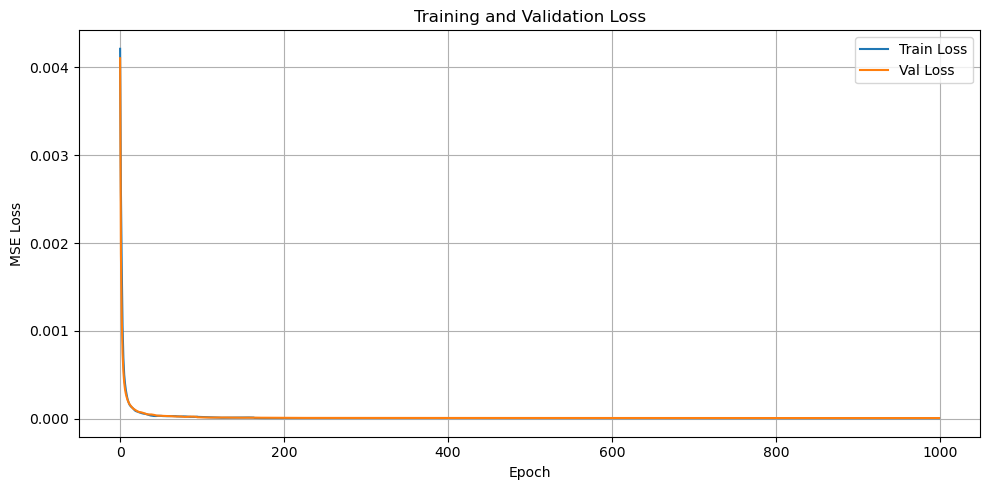

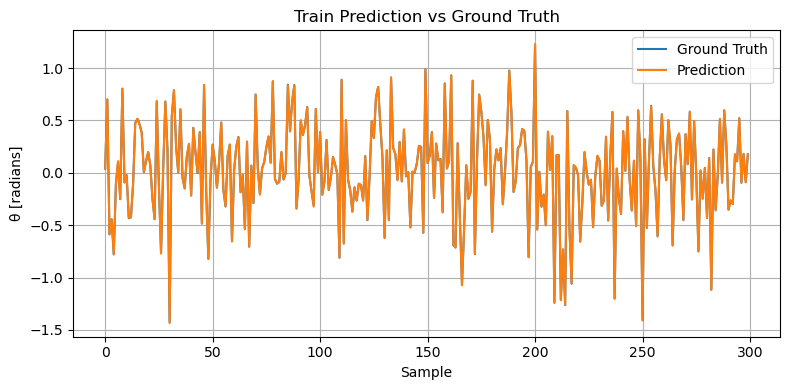

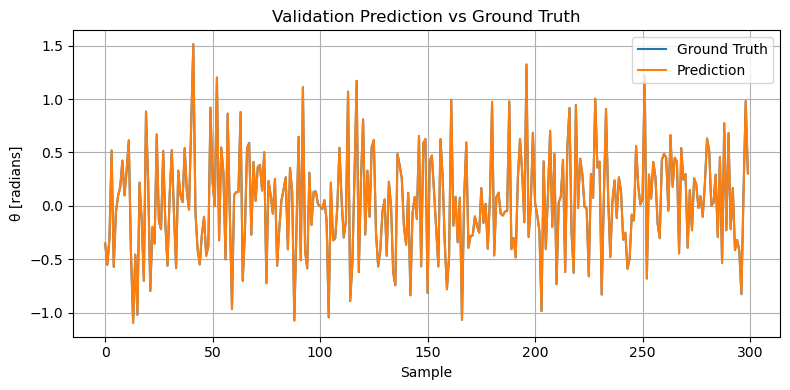

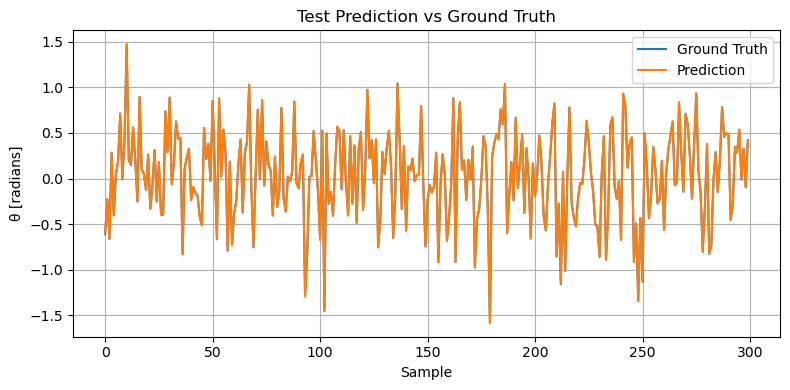

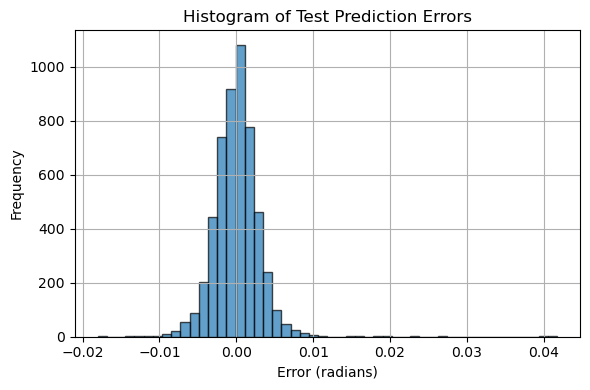

In [15]:
# --- Plot 1: Train/Val Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Train Prediction vs Ground Truth ---
plt.figure(figsize=(8, 4))
plt.plot(Ytrain_final[:300], label='Ground Truth')
plt.plot(train_pred[:300], label='Prediction')
plt.title('Train Prediction vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Val Prediction vs Ground Truth ---
plt.figure(figsize=(8, 4))
plt.plot(Yval[:300], label='Ground Truth')
plt.plot(val_pred[:300], label='Prediction')
plt.title('Validation Prediction vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 4: Test Prediction vs Ground Truth ---
plt.figure(figsize=(8, 4))
plt.plot(Ytest_final[:300], label='Ground Truth')
plt.plot(test_pred[:300], label='Prediction')
plt.title('Test Prediction vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 5: Histogram of Test Errors ---
errors = test_pred - Ytest_final
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Test Prediction Errors')
plt.xlabel('Error (radians)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

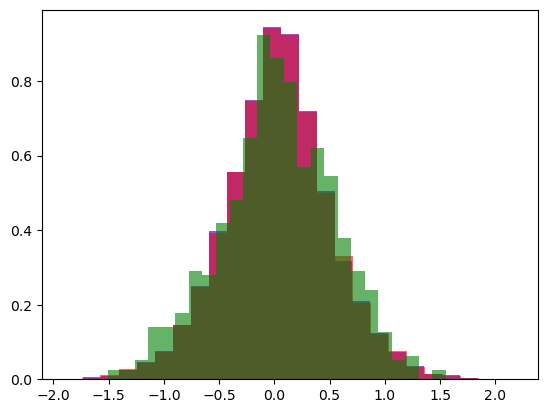

In [12]:
plt.hist(train_pred, bins=25, density=True, alpha=0.6, color='b')
plt.hist(Ytrain, bins=25, density=True, alpha=0.6, color='r')
plt.hist(reg.predict(Xtest), bins=25, density=True, alpha=0.6, color='g')

plt.show()

In [12]:
# def print_model_weights(model):
#     print("Model weights:")
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"\n{name} (shape: {tuple(param.shape)}):")
#             print(param.data.cpu().numpy())  # move to CPU for clean printing

# print_model_weights(model)

Model weights:

layer1.weight (shape: (40, 20)):
[[ 2.14749991e-01 -1.49995934e-01  2.44495801e-01  1.00488245e-01
  -1.07960482e-01  2.30145050e-02 -5.78717320e-02 -1.91457716e-02
   1.69677470e-01  8.61948566e-02  9.96411171e-02 -2.29309350e-01
   1.06476446e-01  7.00354560e-03 -3.92929124e-02  1.21377533e-01
   1.15303600e-01  1.11715053e-01  3.21338761e-01  2.96464811e-01]
 [-8.07083582e-03 -1.13782870e-01  1.51757192e-01  5.59478497e-02
  -2.28789872e-01  1.02610728e-01  1.47269932e-01 -1.32398478e-01
   8.40321048e-02  3.39895064e-02  1.27131687e-03  1.92332269e-01
  -9.34014427e-02 -4.01135121e-02  1.67049122e-01 -1.57876190e-01
  -1.02361201e-01 -2.12907625e-01 -1.48112730e-01 -2.98371409e-01]
 [ 4.49744916e-02  4.97378528e-02 -1.83786270e-01 -8.69986928e-02
   1.10168513e-01 -1.58348017e-01  1.65094193e-01  5.07434958e-03
   4.88385316e-02 -1.16042446e-01  2.43018156e-01 -4.34134074e-02
   5.33929637e-02  2.56396176e-02 -1.10486732e-01 -2.27313336e-01
  -3.62593531e-02 -9.9460